In [1]:
# Added the following lines to upload dataset to google colab, allows me to work
# on labs from multiple machines.
# from google.colab import files
# uploaded = files.upload()

In [35]:
# !pip install pmdarima
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.linear_model import SGDClassifier

# Main Components
## Component 1:
### Dataset loading and fixing [15 points]
Load the dataset, if there is error then use the given code to bypass the warnings/error


In [3]:
df = pd.read_csv('Darknet.CSV', error_bad_lines=False)

<ipython-input-3-9aa0dffa2492>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('Darknet.CSV', error_bad_lines=False)
Skipping line 328: expected 85 fields, saw 125



Change “Label.1” column name to “Darknet Traffic Type”

In [4]:
df = df.rename(columns={'Label.1': 'Darknet Traffic Type'})

Show the distribution of the “Darknet Traffic Type”. Do you see any discrepancies? Is there duplication? If there is any discrepancies fix it.

<Axes: >

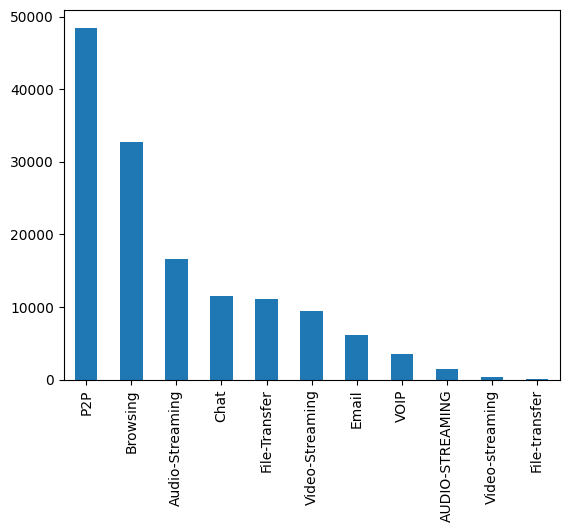

In [5]:
df['Darknet Traffic Type'].value_counts().plot(kind='bar')

Show the fixed distribution in a pie chart using Python, with percentages for each type.


<Axes: ylabel='Darknet Traffic Type'>

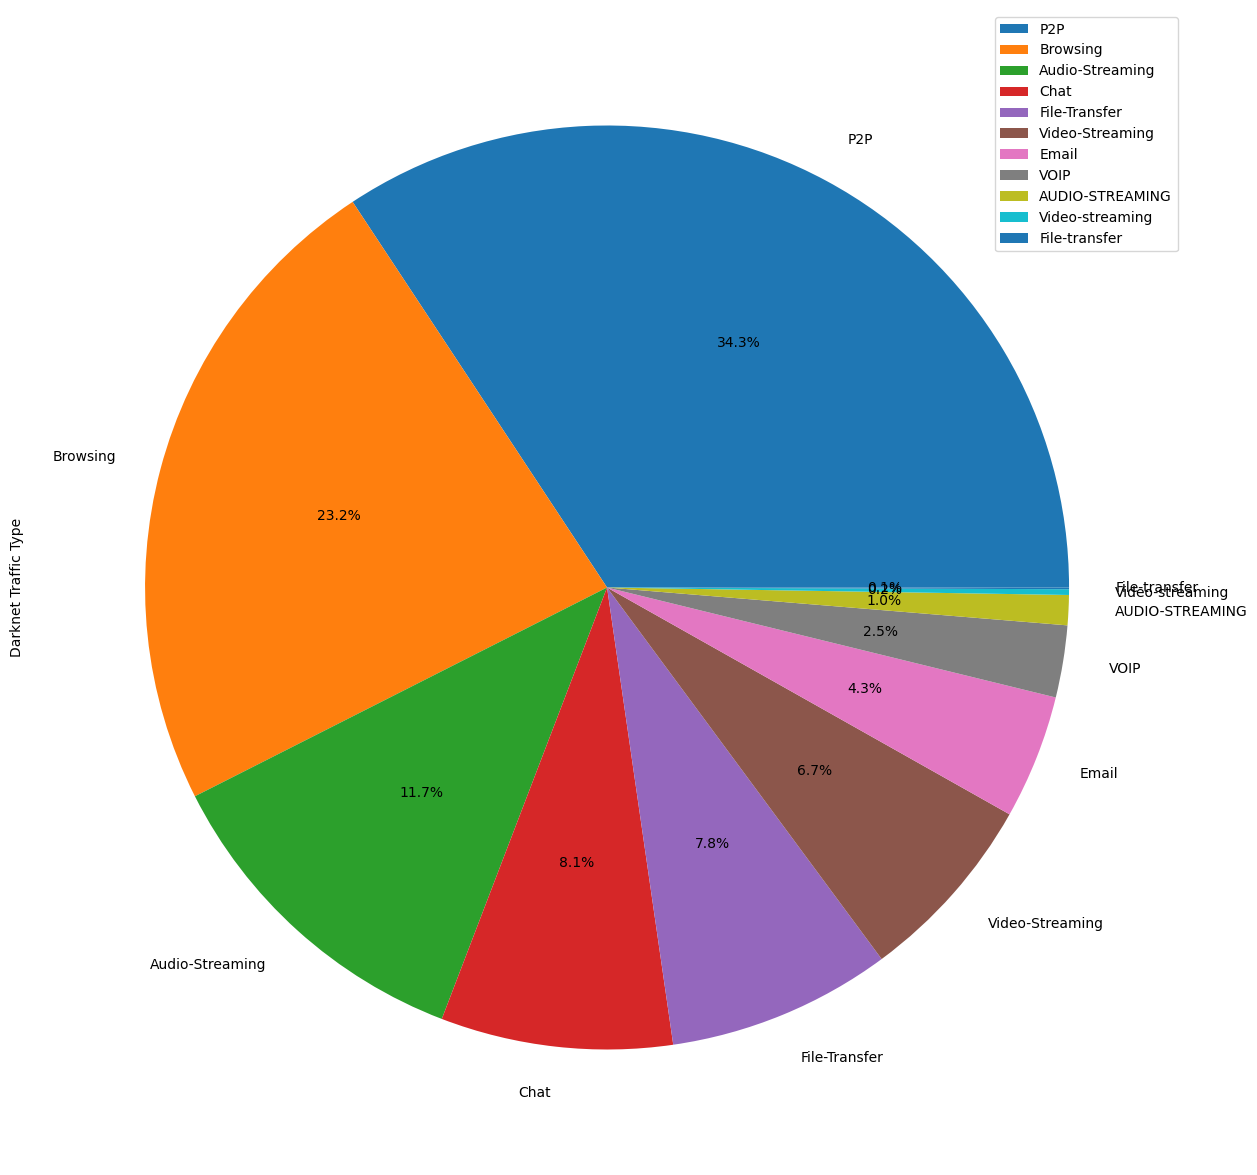

In [6]:
df['Darknet Traffic Type'].value_counts().plot(kind='pie', legend=True, figsize=(15,15), autopct='%1.1f%%')

Show bar graph for “Label” column distribution. How many total traffic categories?


<Axes: >

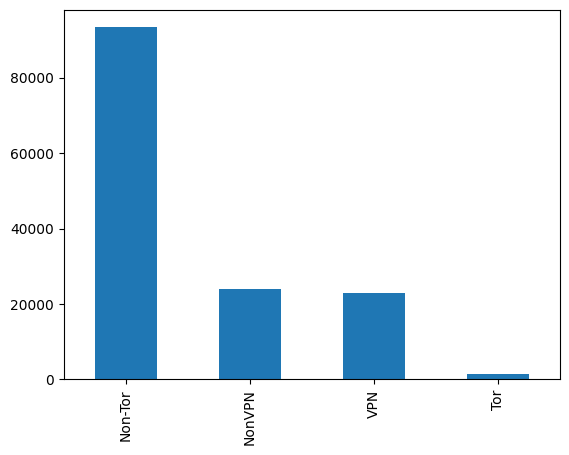

In [7]:
df['Label'].value_counts().plot(kind='bar')

Group “non-VPN” and “non-tor” traffic together as “Benign”. Group “VPN” and “tor” traffic together as “Darknet” for the new set of labels, let’s call is “Final_Label”. This will be later used for binary classification problem.

In [8]:
def get_final_label(s):
  s = s.lower()
  if s == 'non-tor' or s == 'nonvpn':
    return 'Benign'
  elif s == 'vpn' or s == 'tor':
    return 'Darknet'
  else:
    return 'Unknown'

In [9]:
def get_final_label_num(s):
  s = s.lower()
  if s == 'non-tor' or s == 'nonvpn':
    return 0
  elif s == 'vpn' or s == 'tor':
    return 1
  else:
    return 0

In [10]:
labels = df['Label'].to_list()
final_labels = list(map(get_final_label, labels))
df['Final_Label'] = final_labels
num_labels = df['Label'].to_list()
final_num_labels = list(map(get_final_label_num, num_labels))
df['Final_Label_num'] = final_num_labels

If there is null or nan or infinite for any rows, either remove it or use fillna, so that no null value is present in the dataframe. Show the result for your_dataframe.isnull().sum()


In [11]:
df = df.fillna(0)
df.isnull().sum()

Flow ID                 0
Src IP                  0
Src Port                0
Dst IP                  0
Dst Port                0
                       ..
Idle Min                0
Label                   0
Darknet Traffic Type    0
Final_Label             0
Final_Label_num         0
Length: 87, dtype: int64

# 2. Pre-processing the data [10 points]

In [12]:
# n-gram function
def create_grams(ip):
    parts = ip.split('.')
    one_gram = parts[0]
    two_gram = parts[0] + " " + parts[1]
    three_gram = parts[0] + " " + parts[1] + " " + parts[2]
    return one_gram, two_gram, three_gram

Create a new “hour” column from the “timestamp” column for hour based feature extraction


In [13]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [14]:
def get_list_of_hours(dts):
  return dts.hour

In [15]:
datetimes = df['Timestamp'].to_list()
hours = list(map(get_list_of_hours, datetimes))
df['hour'] = hours

Create a column for “src_ip_1gram”. For example, if “src_ip” is 10.35.192.5 then “src_ip_1gram” is 10.

Create a column for “src_ip_2gram”. For example, if “src_ip” is 10.35.192.5 then “src_ip_2gram” is 10 35

Create a column for “src_ip_3gram”. For example, if “src_ip” is 10.35.192.5 then “src_ip_3gram” is 10 35 192

In [16]:
src_ip = df['Src IP'].to_list()

one_gram = []
two_gram = []
three_gram = []

for s in src_ip:
  one, two, three = create_grams(s)
  one_gram.append(one)
  two_gram.append(two)
  three_gram.append(three)

df['src_ip_1gram'] = one_gram
df['src_ip_2gram'] = two_gram
df['src_ip_2gram'] = three_gram

e. How many unique src_ip in the dataset? How many unique dest_ip? How many unique IPs in total combining src_ip and dest_ip?

In [17]:
print('Number of Unique Src Ip\'s: ' + str(len(pd.unique(df['Src IP']))))
print('Number of Unique Dest Ip\'s: ' + str(len(pd.unique(df['Dst IP']))))
total_uniqu = len(pd.unique(df['Src IP'])) + len(pd.unique(df['Dst IP']))
print('Unique Ip\'s Total: ' + str(total_uniqu))

Number of Unique Src Ip's: 3914
Number of Unique Dest Ip's: 7197
Unique Ip's Total: 11111


Irrelevant column removal: FlowID, TimeStamp, Src IP, Dest IP

In [18]:
df = df.drop(columns=['Flow ID', 'Src IP', 'Dst IP'])

If there is categorical columns other that the labels (“Darknet traffic types”,“Label”  or “Final_Label”), then use one-hot encoding to use those columns in the model.

In [19]:
print(df.select_dtypes(include='object'))

encoder = OneHotEncoder()
onehotarray = encoder.fit_transform(df[["Darknet Traffic Type"]]).toarray()
items = [f'{"Darknet Traffic Type"}_{item}' for item in encoder.categories_[0]]
df2 = pd.DataFrame(onehotarray, columns=items)
df = pd.concat([df,df2], axis=1)

encoder = OneHotEncoder()
onehotarray = encoder.fit_transform(df[["Label"]]).toarray()
items = [f'{"Label"}_{item}' for item in encoder.categories_[0]]
df2 = pd.DataFrame(onehotarray, columns=items)
df = pd.concat([df,df2], axis=1)

encoder = OneHotEncoder()
onehotarray = encoder.fit_transform(df[["Final_Label"]]).toarray()
items = [f'{"Final_Label"}_{item}' for item in encoder.categories_[0]]
df2 = pd.DataFrame(onehotarray, columns=items)
df = pd.concat([df,df2], axis=1)

print(df.select_dtypes(exclude='object'))

          Label Darknet Traffic Type Final_Label src_ip_1gram src_ip_2gram
0       Non-Tor      AUDIO-STREAMING      Benign           10   10 152 152
1       Non-Tor      AUDIO-STREAMING      Benign           10   10 152 152
2       Non-Tor      AUDIO-STREAMING      Benign           10   10 152 152
3       Non-Tor      AUDIO-STREAMING      Benign           10   10 152 152
4       Non-Tor      AUDIO-STREAMING      Benign           10   10 152 152
...         ...                  ...         ...          ...          ...
141525      VPN                 VOIP     Darknet           10       10 8 8
141526      VPN                 VOIP     Darknet           10       10 8 8
141527      VPN                 VOIP     Darknet           10       10 8 8
141528      VPN                 VOIP     Darknet           10       10 8 8
141529      VPN                 VOIP     Darknet           80   80 239 235

[141530 rows x 5 columns]
        Src Port  Dst Port  Protocol           Timestamp  Flow Duration  

Again make sure, nan values are dropped or fixed!

In [20]:
df = df.fillna(0)
df.isnull().sum()

Src Port               0
Dst Port               0
Protocol               0
Timestamp              0
Flow Duration          0
                      ..
Label_NonVPN           0
Label_Tor              0
Label_VPN              0
Final_Label_Benign     0
Final_Label_Darknet    0
Length: 104, dtype: int64

Do standard scaling of the data

In [21]:
numeric_df = df._get_numeric_data()
numeric_df = numeric_df.fillna(0)
numeric_df.replace([np.inf, -np.inf], 0, inplace=True)
sc = StandardScaler()
sc.fit(numeric_df)
scaled_df = sc.transform(numeric_df)

a. Show a kernel density plot by grouping the data into “darknet” vs “benign” for the hourly distribution of traffic activities (x-axis should represent hours).

In [22]:
df['Final_Label']

0          Benign
1          Benign
2          Benign
3          Benign
4          Benign
           ...   
141525    Darknet
141526    Darknet
141527    Darknet
141528    Darknet
141529    Darknet
Name: Final_Label, Length: 141530, dtype: object

<ipython-input-23-4cad6f33708a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  darknet_data['hour'] = darknet_data['Timestamp'].dt.hour
<ipython-input-23-4cad6f33708a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benign_data['hour'] = benign_data['Timestamp'].dt.hour


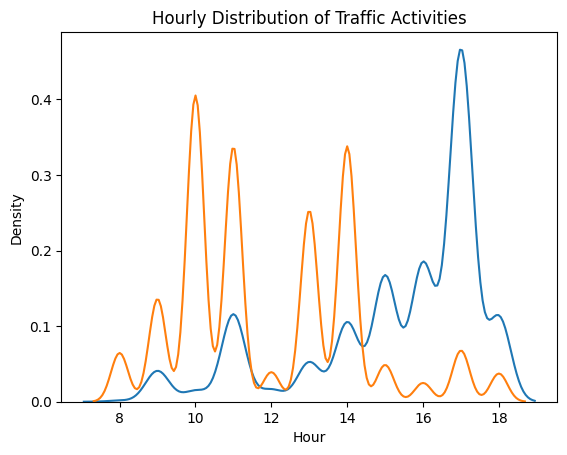

In [23]:
darknet_data = df[df['Final_Label'] == 'Darknet']
benign_data = df[df['Final_Label'] == 'Benign']
darknet_data['hour'] = darknet_data['Timestamp'].dt.hour
benign_data['hour'] = benign_data['Timestamp'].dt.hour
sns.kdeplot(data=darknet_data, x='hour', label='Darknet')
sns.kdeplot(data=benign_data, x='hour', label='Benign')
plt.title('Hourly Distribution of Traffic Activities')
plt.xlabel('Hour')
plt.ylabel('Density')
plt.show()

b. Show the probability distribution of certain traffic types (e.g., Audio-Streaming, P2P, email, …) given the row is “benign” (Final_Label= “benign”).

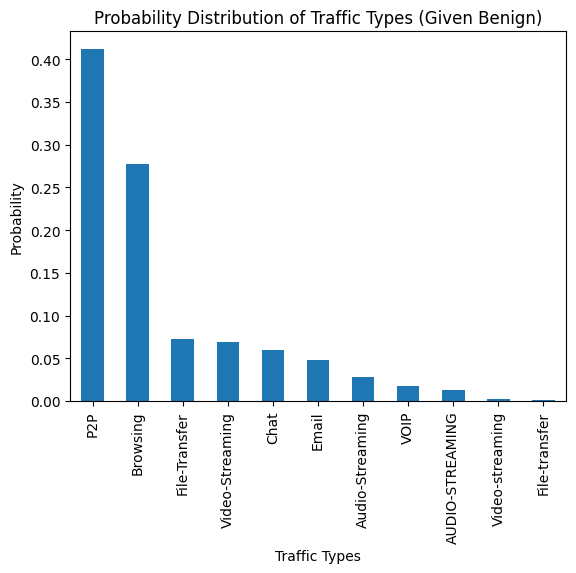

In [24]:
benign_traffic = df[df['Final_Label'] == 'Benign']
prob_distribution = benign_traffic['Darknet Traffic Type'].value_counts(normalize=True)
prob_distribution.plot(kind='bar')
plt.title('Probability Distribution of Traffic Types (Given Benign)')
plt.xlabel('Traffic Types')
plt.ylabel('Probability')
plt.show()

Show the probability distribution of certain traffic types (e.g., Audio-Streaming, P2P, email, …) given the data is “darknet” (Final_Label = “darknet”).

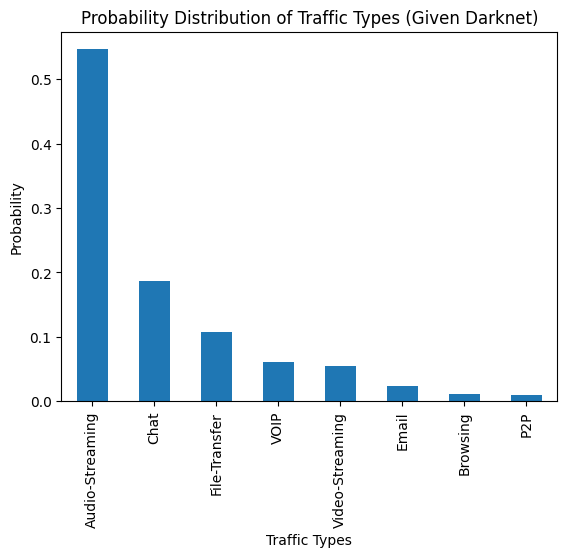

In [25]:
darknet_traffic = df[df['Final_Label'] == 'Darknet']
prob_distribution = darknet_traffic['Darknet Traffic Type'].value_counts(normalize=True)
prob_distribution.plot(kind='bar')
plt.title('Probability Distribution of Traffic Types (Given Darknet)')
plt.xlabel('Traffic Types')
plt.ylabel('Probability')
plt.show()

d. Analyze and present different columns/variables and see if there is any significant difference between the groups “darknet” vs “benign” for any specific column? Show evidence if found such relationship.

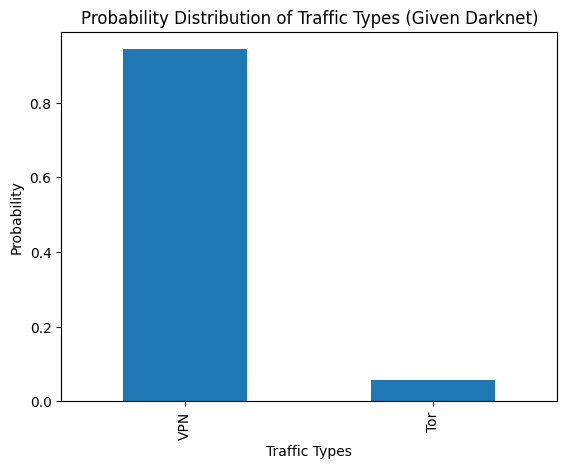

In [26]:
prob_distribution = darknet_traffic['Label'].value_counts(normalize=True)
prob_distribution.plot(kind='bar')
plt.title('Probability Distribution of Traffic Types (Given Darknet)')
plt.xlabel('Traffic Types')
plt.ylabel('Probability')
plt.show()

 Analyze and present different columns/variables and see if there is any significant difference among the darknet Traffic Types (Column: “Darknet Traffic Type”) for any specific column? Show evidence if found such relationship.

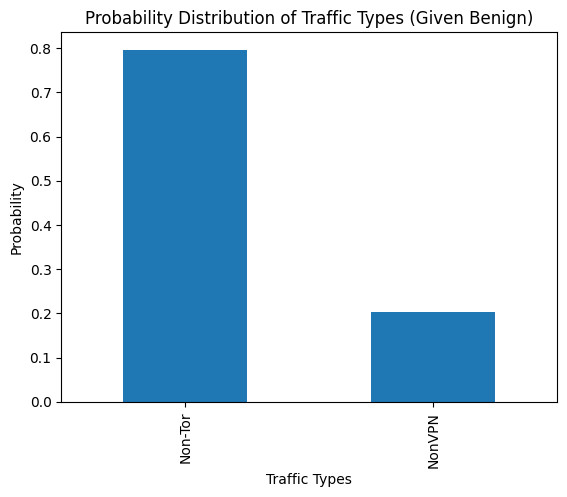

In [27]:
prob_distribution = benign_traffic['Label'].value_counts(normalize=True)
prob_distribution.plot(kind='bar')
plt.title('Probability Distribution of Traffic Types (Given Benign)')
plt.xlabel('Traffic Types')
plt.ylabel('Probability')
plt.show()

To the standard ML based modeling that we learned through the labs. [Make your judgements and knowledge to make sure if any intermediate step is required or optional]

Do you need to fix data imbalance issue? If needed, apply a technique to do so.

In [300]:
X = df.drop('Final_Label', axis=1)
Y = df['Final_Label']
original_distribution = Y.value_counts()
print("Original Training Set Distribution:")
print(original_distribution)
x1 = 117219
y1 = 24311
percent = (y1/x1) * 100
print(f'Data Balance: {percent}%')

Original Training Set Distribution:
Benign     117219
Darknet     24311
Name: Final_Label, dtype: int64
Data Balance: 20.739811805253414%


 Do apply at least 6 State-of-the -art ML models of your choice (e.g., Random Forest, Decision Tree, SVM, Logistic Regression, KNN, etc.) for the binary classification job of identifying “benign” vs “darknet” traffic labels (reference column “Final_label”).

In [29]:
y = df['Final_Label_num']
x_train,x_test,y_train,y_test = train_test_split(numeric_df,y,test_size=0.2)

# Random Forest Classifier:

In [30]:
classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:", accuracy)
print(classification_report(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
fpr = fp/(fp+tn)
fnr = fn/(tp+fn)
print(f'FPR: {fpr}\nFNR: {fnr}')

Accuracy score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23515
           1       1.00      1.00      1.00      4791

    accuracy                           1.00     28306
   macro avg       1.00      1.00      1.00     28306
weighted avg       1.00      1.00      1.00     28306

FPR: 0.0
FNR: 0.0


# Decision Tree Classifier

In [31]:
classifier = DecisionTreeClassifier()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:", accuracy)
print(classification_report(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
fpr = fp/(fp+tn)
fnr = fn/(tp+fn)
print(f'FPR: {fpr}\nFNR: {fnr}')

Accuracy score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23515
           1       1.00      1.00      1.00      4791

    accuracy                           1.00     28306
   macro avg       1.00      1.00      1.00     28306
weighted avg       1.00      1.00      1.00     28306

FPR: 0.0
FNR: 0.0


# Logistic Regression

In [32]:
classifier = LogisticRegression()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:", accuracy)
print(classification_report(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
fpr = fp/(fp+tn)
fnr = fn/(tp+fn)
print(f'FPR: {fpr}\nFNR: {fnr}')

Accuracy score: 0.8307425987423162
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     23515
           1       0.00      0.00      0.00      4791

    accuracy                           0.83     28306
   macro avg       0.42      0.50      0.45     28306
weighted avg       0.69      0.83      0.75     28306

FPR: 0.0
FNR: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

# Scalable Vector Machine:

In [33]:
x_train,x_test,y_train,y_test = train_test_split(scaled_df,y,test_size=0.2)
classifier = svm.SVC()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:", accuracy)
print(classification_report(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
fpr = fp/(fp+tn)
fnr = fn/(tp+fn)
print(f'FPR: {fpr}\nFNR: {fnr}')

Accuracy score: 0.9996467180103158
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23460
           1       1.00      1.00      1.00      4846

    accuracy                           1.00     28306
   macro avg       1.00      1.00      1.00     28306
weighted avg       1.00      1.00      1.00     28306

FPR: 0.0
FNR: 0.0020635575732562937


# K Neighbor Classifier

In [34]:
classifier = KNeighborsClassifier()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:", accuracy)
print(classification_report(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
fpr = fp/(fp+tn)
fnr = fn/(tp+fn)
print(f'FPR: {fpr}\nFNR: {fnr}')

Accuracy score: 0.999752702607221
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23460
           1       1.00      1.00      1.00      4846

    accuracy                           1.00     28306
   macro avg       1.00      1.00      1.00     28306
weighted avg       1.00      1.00      1.00     28306

FPR: 4.262574595055413e-05
FNR: 0.0012381345439537762


# Stochastic Gradient Descent

In [38]:
classifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:", accuracy)
print(classification_report(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
fpr = fp/(fp+tn)
fnr = fn/(tp+fn)
print(f'FPR: {fpr}\nFNR: {fnr}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy score: 0.9999293436020632
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23460
           1       1.00      1.00      1.00      4846

    accuracy                           1.00     28306
   macro avg       1.00      1.00      1.00     28306
weighted avg       1.00      1.00      1.00     28306

FPR: 0.0
FNR: 0.0004127115146512588


Provide a tabular presentation of the standard evaluation metric to report the best performing model in your case study. Do you find one single best model that outperforms all other in every metrics? Or you can report individual metric based highest/top performing models.

In [303]:
# from google.colab import files
# uploaded = files.upload()
df2 = pd.read_csv('FinalProject - Sheet1.csv')
print(df2)

            Unnamed: 0       FPR       FNR  Accuracy  F1-Score
0                  KNC  0.353635  0.058712  0.796528      0.76
1                   RF  0.025157  0.692308  0.915966      0.95
2                  SVM  0.064833  0.041667  0.946962      0.95
3        Decision Tree  0.481336  0.041667  0.742527      0.73
4  Logistic Regression  0.006452  0.021277  0.830743      0.91
5                  SGD  0.025157  0.692308  0.855634      0.95


Using the timseries data for Darknet events (e.g., only Final_Label=“darknet”). Can we generate a model to forecast predictions fr number of Darknet events?

Hint: in this task you need to create a time-series DF first with days (dates) and number of darknet traffic events. Once that is generated you separate the train-test. Make sure training has 90% of the days ad you will be predicting te remaining 10 of days.

In [297]:
df.sort_values(by='Timestamp')
ts = pd.DataFrame()
ts['Dates'] = df['Timestamp']
ts['#Attacks'] = df['Final_Label_num']
ts = ts.groupby(pd.Grouper(key='Dates', axis=0, freq='10D')).sum()

In [301]:
train_size = int(len(ts) * 0.9)
train = ts[:train_size]
test = ts[train_size:]

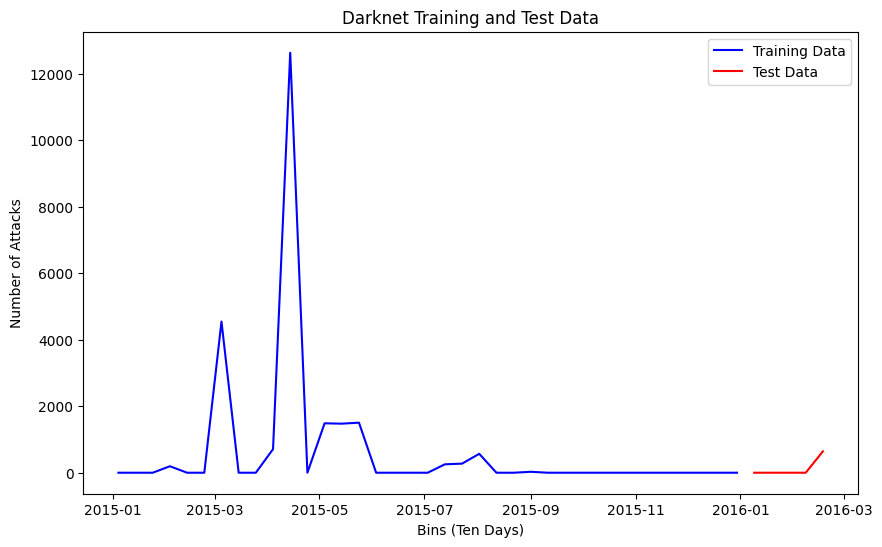

In [295]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['#Attacks'], color='blue', label='Training Data')
plt.plot(test.index, test['#Attacks'], color='red', label='Test Data')
plt.xlabel('Bins (Ten Days)')
plt.ylabel('Number of Attacks')
plt.title('Darknet Training and Test Data')
plt.legend()
plt.show()

In [296]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=677.173, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=679.182, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=679.177, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=678.282, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=681.356, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.838 seconds
RMSE:  572.1452492744728
